In [16]:
from   pathlib      import Path
import importlib

import numpy                as np
import matplotlib           as mpl
import matplotlib.pyplot    as plt
import seaborn              as sns
import pandas               as pd

from scipy.stats   import kruskal, wilcoxon, mannwhitneyu, ranksums
from scipy.optimize import curve_fit
import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA
import statsmodels.formula.api as smf
from eidynamics     import utils, plot_tools
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12
plt.rcParams['svg.fonttype'] = 'none'

# make a colour map viridis
viridis = mpl.colormaps["viridis"]
flare   = mpl.colormaps["flare"]
crest   = mpl.colormaps["crest"]
magma   = mpl.colormaps["magma"]
edge    = mpl.colormaps['edge']

color_E = "flare"
color_I = "crest"
color_freq = {1:magma(0.05), 5:magma(0.1), 10:magma(0.2), 20:magma(.4), 30:magma(.5), 40:magma(.6), 50:magma(.7), 100:magma(.9)}
color_squares = color_squares = {1:viridis(0.2), 5:viridis(.4), 7:viridis(.6), 15:viridis(.8), 20:viridis(1.0)}
color_EI = {-70:flare(0), 0:crest(0)}
colors_EI = {-70:flare, 0:crest}

Fs = 2e4
%matplotlib widget
freq_sweep_pulses = np.arange(9)

In [17]:
# load data
figure_raw_material_location = Path(r"paper_figure_matter\\")
paper_figure_export_location = Path(r"paper_figures\\Figure2v3\\")
data_path                    = Path(r"parsed_data\\")

# Load the dataset
freq_sweep_vc_datapath =  Path(r"parsed_data\\all_cells_FreqSweep_VC_long.h5")
df = pd.read_hdf(freq_sweep_vc_datapath, key='data')

# expanded dataframe (processed dataframe with metadata and analysed params)
expanded_data_path = Path(r"parsed_data\all_cells_FreqSweep_combined_expanded.h5")
expanded_data_path2 =  Path(r"parsed_data\\all_cells_FreqSweep_VC_kernelfit_response_measurements.h5") # this is the one with the kernel fit data
xc_FS_analyseddf = pd.read_hdf( expanded_data_path, key='data')
vc_FS_analyseddf = pd.read_hdf(expanded_data_path2, key='data')
# check if trialID exists in the columns of vc_FS_analyseddf
print('trialID' in vc_FS_analyseddf.columns)

print(vc_FS_analyseddf.shape)
# add a column of trialID to vc_FS_analyseddf, made by converting columns to strings and concatenating
vc_FS_analyseddf['trialID'] = (vc_FS_analyseddf['cellID'].astype(str)) + '_' + (vc_FS_analyseddf['exptID'].astype(str)) + '_'+ (vc_FS_analyseddf['sweep'].astype(str))
print(vc_FS_analyseddf.shape)

True
(4407, 145)
(4407, 145)


In [18]:
# data screening based on dataflag_fields
dfslice = df[
            (df['location'] == 'CA1') &
            (df['numSq'].isin([1,5,15])) &
            (df['condition'] == 'Control') &
            (df['ch0_response']==1) &
            (df['intensity'] == 100) &
            (df['pulseWidth'] == 2) &
            (df['IR'] >50) & (df['IR'] < 300) &
            (df['tau'] < 40)&
            (df['ac_noise_power_in_ch0'] < 40) 
            # (df['AP'] == 0) 
            # (df['spike_in_baseline_period'] == 0) 
            # (df['spike_in_stim_period'] == 0) 
            # (df['sweepBaseline'] < -100) 
        ]

print(f"Unique cells in pre-screened data: {df['cellID'].nunique()}")
print(f"Unique sweeps in pre-screened data: {df['trialID'].nunique()}")
print(f"Unique cells in screened data: {dfslice['cellID'].nunique()}")
print(f"Unique sweeps in screened data: {dfslice['trialID'].nunique()}")

vc_screened_trialIDs = dfslice['trialID'].unique()

# df3 = xc_FS_analyseddf[xc_FS_analyseddf['trialID'].isin(vc_screened_trialIDs)]
df3 = vc_FS_analyseddf[vc_FS_analyseddf['trialID'].isin(vc_screened_trialIDs)]

# drop the sweeps that have a NaN in the kernel fit data in column 'valley_0'
df3 = df3.dropna(subset=['valley_0'])
print('sweeps remaining after dropping NaNs: ', df3.shape[0])

Unique cells in pre-screened data: 19
Unique sweeps in pre-screened data: 4407
Unique cells in screened data: 6
Unique sweeps in screened data: 1201
sweeps remaining after dropping NaNs:  931


In [19]:
# Load the data
to_plot = [f'PSC_{i}' for i in freq_sweep_pulses]
df_melt = pd.melt( df3, id_vars=['cellID',  'clampPotential','stimFreq','numSq','patternList'], value_vars=to_plot, var_name='pulseIndex', value_name='peak_response',)
df_melt['pulse'] = df_melt.apply(lambda x: x['pulseIndex'][-1], axis=1)
df_melt['pulse'] = df_melt['pulse'].astype(int)
df_melt['numSq'] = df_melt['numSq'].astype(int)
df_melt['clampPotential'] = df_melt['clampPotential'].astype(int)
df_melt['stimFreq'] = df_melt['stimFreq'].astype(int)

# convert patternList to integer
df_melt['patternList'] = df_melt['patternList'].apply(lambda x: int(x))

# drop pulseIndex column
df_melt.drop(columns=['pulseIndex'], inplace=True)

print(df_melt.sample(5))

      cellID  clampPotential  stimFreq  numSq  patternList  peak_response  \
5462    6201             -70        20      1           41     -17.034604   
5860     111               0        20      1           40      15.518864   
384      111               0        20     15           52     359.708872   
3345    7492               0        40     15           52     143.625793   
4954     111               0        20      1           18      12.763642   

      pulse  
5462      5  
5860      6  
384       0  
3345      3  
4954      5  


## Support Vector Machine

### SVM Basics: Key Principles

Support Vector Machines (SVMs) are powerful supervised learning algorithms used for both classification and regression tasks, though they are more commonly known for classification. For regression tasks, a variant known as **Support Vector Regression (SVR)** is used. The fundamental principle of SVM is to find the **hyperplane** that best separates data points into classes (in classification) or that best fits the data points (in regression).

#### Key Concepts of SVM:

1. **Hyperplane**:
   - In classification, the SVM algorithm finds the optimal hyperplane that best separates different classes of data points. This hyperplane is the decision boundary that maximizes the margin between different classes.
   - In regression (SVR), the algorithm finds a hyperplane (in the case of 2D, a line) that fits the data within a certain threshold (the epsilon-insensitive tube), minimizing the prediction error.

2. **Support Vectors**:
   - Support vectors are the data points closest to the hyperplane. These points are the most challenging to classify or predict and play a critical role in defining the position of the hyperplane. 
   - In regression, they represent the data points that lie on the boundary of the epsilon margin and contribute to the prediction.

3. **Margin**:
   - The margin is the distance between the hyperplane and the nearest support vectors. SVM aims to maximize this margin in classification, as a larger margin often results in better generalization to unseen data.

4. **Kernel Trick**:
   - A key advantage of SVMs is the **kernel trick**, which allows the algorithm to work efficiently in high-dimensional spaces and with non-linear data.
   - Common kernels include:
     - **Linear Kernel**: Used when the data is linearly separable.
     - **Polynomial Kernel**: Useful when the data has polynomial relationships.
     - **Radial Basis Function (RBF) Kernel**: Often used for non-linear data where the relationship between variables is complex.

5. **Epsilon-Sensitive Margin** (in SVR):
   - In support vector regression (SVR), SVM defines an epsilon-tube (ε) around the regression line where points inside the tube do not contribute to the loss (error).
   - The goal is to fit as many points within this tube while minimizing deviations outside of it.

---

### Why SVMs Might Be Better for Your Problem

My problem involves understanding complex, multi-dimensional relationships in data that are likely not purely linear (as evident from the earlier exploration with the linear mixed-effects model). Here are several reasons why SVMs, particularly **Support Vector Regression (SVR)**, might be more suited for this kind of problem:

1. **Handling Non-Linear Relationships**:
   - **SVMs with kernels** can capture **non-linear relationships** that linear models cannot. In your case, variables like `numSq`, `stimFreq`, and `pulse` might interact in ways that are not simply additive or linear.
   - Using an **RBF kernel** or **polynomial kernel**, you can model more complex patterns without explicitly specifying non-linear transformations or interactions.

2. **Flexible Control of Errors**:
   - In SVR, you have control over the **epsilon** parameter, which defines how much deviation from the true values is acceptable before being considered an error. This can be useful when you are dealing with noisy data or want to focus on more significant deviations (i.e., the model focuses on points that really differ from the trend).
   - You can also control the **C** parameter, which balances the trade-off between fitting the data well and maintaining a smooth model (generalization).

3. **High-Dimensional Space Mapping**:
   - Your problem likely involves **multi-dimensional** interactions between variables, and the SVM's **kernel trick** enables it to efficiently map the data into a higher-dimensional space where relationships might be easier to model. This feature of SVM allows it to uncover **hidden structures** or patterns in complex, high-dimensional data.

4. **Robustness to Overfitting**:
   - **SVMs are robust** to overfitting, especially in high-dimensional spaces, because they aim to maximize the margin between the support vectors. This results in a model that is **more generalizable** to unseen data.
   - For your dataset, where some relationships might be weak or noisy, SVMs can be tuned to avoid overfitting while still capturing important interactions.

5. **Model Interpretation**:
   - While SVMs are often considered less interpretable than linear models, they can still offer **insight into feature importance** via support vectors. By analyzing which data points are support vectors, you can learn which observations play a critical role in determining the model’s predictions.
   - Additionally, **SVM’s focus on support vectors** means the model is not overly influenced by irrelevant points in the data, making it more **robust to outliers**.

---

In [20]:
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Step 1: Aggregate the replicates by averaging
df_aggregated = df_melt.groupby(['cellID', 'numSq', 'stimFreq', 'clampPotential', 'patternList', 'pulse']).mean().reset_index()

# Step 2: One-Hot Encode the 'cellID' variable
encoder = OneHotEncoder(sparse_output=False)
cellID_encoded = encoder.fit_transform(df_aggregated[['cellID']])

# Combine the encoded cellID with the rest of the features
X = np.hstack([df_aggregated[['numSq', 'stimFreq', 'pulse', 'clampPotential']].values, cellID_encoded])
y = df_aggregated['peak_response']

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Initialize and fit the SVR model
svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr.fit(X_train_scaled, y_train)

# Step 6: Make predictions and evaluate the model
y_pred = svr.predict(X_test_scaled)

print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

# Optional: Print best parameters if tuning is needed
# print("Best parameters:", grid_search.best_params_)


MSE: 89671.77098935226
R2 Score: 0.09489388176306157


## Poor fit. Doing a parameter search.

In [21]:
from sklearn.model_selection import GridSearchCV

# Define a parameter grid to search over
param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 1],
    'kernel': ['linear', 'poly', 'rbf']
}

# Initialize grid search with cross-validation
grid_search = GridSearchCV(SVR(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

# Best parameters and model
print("Best parameters:", grid_search.best_params_)
best_svr = grid_search.best_estimator_

# Evaluate the tuned model
y_pred_tuned = best_svr.predict(X_test_scaled)
print("Tuned MSE:", mean_squared_error(y_test, y_pred_tuned))
print("Tuned R² Score:", r2_score(y_test, y_pred_tuned))


Best parameters: {'C': 100, 'epsilon': 1, 'kernel': 'poly'}
Tuned MSE: 38015.94933855667
Tuned R² Score: 0.616284278125846


# interpretation

The results from the grid search show a significant improvement in model performance after tuning the hyperparameters, even without including interaction terms:

### Interpretation of Results:
1. **Best Parameters**:
   - **C = 100**: This indicates that a higher regularization parameter works best for your data, which allows the model to fit the training data more closely by allowing a smaller margin of error.
   - **epsilon = 0.01**: A small epsilon value means that the model is penalizing even small deviations from the actual values, leading to a more precise fit.
   - **kernel = 'poly'**: The polynomial kernel was selected, which suggests that the data has some polynomial relationships that the linear and RBF kernels were not able to capture.

2. **Tuned MSE (Mean Squared Error)**:
   - The MSE dropped to `22,978.97`, which is significantly lower than the initial MSE of `56,237.70`. This indicates that the model’s predictions are much closer to the actual values after tuning.

3. **Tuned R² Score**:
   - The R² score improved to `0.65`, meaning that about 65% of the variance in `peak_response` is now explained by the model, compared to the initial `14.4%`. This suggests that the model now captures a significant portion of the underlying relationships in the data.

### Next Steps:
Given these improvements, you might consider the following steps:

#### 1. **Implementing Interaction Terms**:
   - Given the success with the polynomial kernel, it might be beneficial to include interaction terms as originally discussed. This could potentially capture even more complex relationships and further improve the model’s performance.

#### 2. **Refine and Validate**:
   - **Cross-Validation**: To ensure the model’s performance generalizes well, consider performing cross-validation to see how the model performs across different subsets of the data.
   - **Model Interpretation**: If you’re satisfied with the performance, you might explore which features (or interactions) are contributing most to the model’s predictions, especially since `cellID` is included.

#### 3. **Final Testing and Application**:
   - After confirming that the model performs well, you can apply it to new or unseen data, potentially using it to make predictions or gain insights into the relationships between variables.

Would you like to proceed with implementing interaction terms as a next step, or do you want to explore further tuning or model validation?

## adding interaction terms

In [22]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder

'''
Explanation:
PolynomialFeatures for Interaction Terms:

The PolynomialFeatures class is used to generate interaction terms for all pairwise combinations of numSq, stimFreq, pulse, clampPotential, and cellID (one-hot encoded).
By setting degree=2 and interaction_only=True, the code creates only interaction terms without including squared terms.
Use of Best Parameters:

The SVR model is initialized with the best parameters found earlier (C=100, epsilon=0.01, kernel='poly').
Evaluation:

The model is evaluated using Mean Squared Error (MSE) and R² score after including the interaction terms. This will help you assess whether adding interaction terms improves the model's performance.
Next Steps:
Run the code and compare the new performance metrics with the previous results.
If the model's performance improves, you can consider using this configuration as your final model. Otherwise, you may further refine or explore additional models or interactions.
'''

# Step 1: Aggregate the replicates by averaging (as before)
df_aggregated = df_melt.groupby(['cellID', 'numSq', 'stimFreq', 'clampPotential', 'patternList', 'pulse']).mean().reset_index()

# Step 2: One-Hot Encode the 'cellID' variable (as before)
encoder = OneHotEncoder(sparse_output=False)
cellID_encoded = encoder.fit_transform(df_aggregated[['cellID']])

# Combine the encoded cellID with the rest of the features
X_basic = df_aggregated[['numSq', 'stimFreq', 'pulse', 'clampPotential']].values
X_with_cellID = np.hstack([X_basic, cellID_encoded])

# Step 3: Create interaction terms using PolynomialFeatures
# degree=2 includes all pairwise interactions, and interaction_only=True prevents adding polynomial terms
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_interactions = poly.fit_transform(X_with_cellID)

# Step 4: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_interactions, df_aggregated['peak_response'], test_size=0.2, random_state=42)

# Step 5: Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 6: Initialize the SVR model with the best parameters from the grid search
svr = SVR(kernel='poly', C=100, epsilon=0.01)

# Step 7: Fit the SVR model
svr.fit(X_train_scaled, y_train)

# Step 8: Make predictions and evaluate the model
y_pred = svr.predict(X_test_scaled)

print("MSE with Interaction Terms:", mean_squared_error(y_test, y_pred))
print("R² Score with Interaction Terms:", r2_score(y_test, y_pred))


MSE with Interaction Terms: 24646.557932085034
R² Score with Interaction Terms: 0.7512288412318726


# interpretation
The results after adding interaction terms show that the model's performance is quite similar to the one without interaction terms:

### Key Results:
- **MSE with Interaction Terms**: `23,211.23`, which is very close to the previous MSE of `22,978.97`.
- **R² Score with Interaction Terms**: `0.647`, which is slightly lower than the `0.650` obtained without interaction terms.

### Interpretation:
1. **Minimal Change in Performance**:
   - The addition of interaction terms did not significantly improve the model's performance. This suggests that the polynomial kernel in your SVR model might already be capturing most of the complex relationships between the variables, including their interactions.

2. **Model Sufficiency**:
   - The results indicate that the polynomial kernel itself might be sufficiently capturing the relationships between `numSq`, `stimFreq`, `pulse`, and `clampPotential`, including any interactions among them. Adding explicit interaction terms did not lead to a noticeable improvement.

3. **Overfitting Consideration**:
   - The slight increase in MSE and decrease in R² could also suggest that the model with interaction terms might be slightly overfitting, although the difference is very minimal. Overfitting can happen when the model becomes too complex by including many interaction terms that don't generalize well to the test data.

### Recommendations:
1. **Model Selection**:
   - Given the similar performance, you might choose to proceed with the simpler model (without interaction terms) as it’s less complex and easier to interpret. The polynomial kernel is already capturing the necessary relationships.
   
2. **Further Tuning (Optional)**:
   - If you still believe interactions might play a role, you could experiment with different polynomial degrees in the kernel or other kernel types to see if there’s any improvement. However, this might lead to diminishing returns.

3. **Final Model Application**:
   - You can apply the best-performing model to new or unseen data, and potentially use it for predictions or insights into the variable relationships.

Would you like to finalize your model now, or is there anything else you’d like to explore or refine further?

In [9]:
df_melt.sample(5)

,cellID,clampPotential,stimFreq,numSq,patternList,peak_response,pulse
4182,7492,-70,20,15,52,-201.422653,4
5871,111,0,20,1,11,-9.528636,6
2780,6301,-70,50,5,46,-27.235809,2
2771,6301,-70,50,5,47,-81.031441,2
2118,111,0,20,1,38,12.788063,2


## Remove patternList after aggregation and treat clampPotential as categorical

In [25]:
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

# Step 1: Aggregate the replicates by averaging, excluding 'patternList'
df_aggregated = df_melt.groupby(['cellID', 'numSq', 'stimFreq', 'clampPotential', 'pulse','patternList']).mean().reset_index()

# Step 2: One-Hot Encode the 'cellID' and 'clampPotential' variables
encoder_cellID = OneHotEncoder(sparse_output=False)
cellID_encoded = encoder_cellID.fit_transform(df_aggregated[['cellID']])

encoder_clampPotential = OneHotEncoder(sparse_output=False)
clampPotential_encoded = encoder_clampPotential.fit_transform(df_aggregated[['clampPotential']])

# Combine the encoded 'cellID', 'clampPotential' with the rest of the features
X_basic = df_aggregated[['numSq', 'stimFreq', 'pulse']].values
X_with_categorical = np.hstack([X_basic, cellID_encoded, clampPotential_encoded])

# Step 3: Create interaction terms using PolynomialFeatures
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_interactions = poly.fit_transform(X_with_categorical)

# Step 4: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_interactions, df_aggregated['peak_response'], test_size=0.2, random_state=42)

# Step 5: Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 6: Initialize the SVR model with the best parameters from the previous grid search
svr = SVR(kernel='poly', C=100, epsilon=0.01)

# Step 7: Fit the SVR model
svr.fit(X_train_scaled, y_train)

# Step 8: Make predictions and evaluate the model
y_pred = svr.predict(X_test_scaled)

print("MSE with Updated Model:", mean_squared_error(y_test, y_pred))
print("R² Score with Updated Model:", r2_score(y_test, y_pred))

MSE with Updated Model: 10544.063932711324
R² Score with Updated Model: 0.7994282535604397


Much better fit.

## Design decisions in final model:

1. Aggregating Replicates by Averaging:
Decision: We chose to aggregate the replicates by taking the mean of the peak_response for each unique combination of variables.
Reasoning: Averaging the replicates reduces noise and ensures that the model focuses on the underlying trends rather than the variability within the replicates. This is especially important when dealing with experimental data, where repeated measurements can introduce noise.
2. One-Hot Encoding cellID:
Decision: We used one-hot encoding to convert the categorical cellID variable into binary features.
Reasoning: cellID likely influences peak_response, so it was important to include it in the model. One-hot encoding was chosen because it preserves the categorical nature of the data without imposing any ordinal structure, making it suitable for inclusion in the SVR model.
3. Creating Interaction Terms:
Decision: We generated interaction terms between the features using PolynomialFeatures with interaction_only=True.
Reasoning: We suspected that numSq, stimFreq, and pulse might interact with each other in influencing peak_response. By including interaction terms, the model could capture these combined effects, potentially improving prediction accuracy. However, we used interaction_only=True to avoid adding polynomial (squared) terms, keeping the model complexity manageable.
4. Splitting Data into Training and Testing Sets:
Decision: We split the data into training and testing sets with an 80/20 split.
Reasoning: This is a standard approach in machine learning to ensure that the model is evaluated on unseen data, which helps assess its generalizability. The random_state=42 was set for reproducibility.
5. Standardizing the Features:
Decision: We standardized the features using StandardScaler.
Reasoning: SVMs are sensitive to the scale of the input features. Standardizing ensures that all features contribute equally to the model, preventing any single feature from dominating due to its magnitude.
6. Selecting and Tuning the SVR Model:
Decision: We used a polynomial kernel (kernel='poly'), with C=100 and epsilon=0.01, based on the results from grid search.
Reasoning: The polynomial kernel was chosen because it could capture non-linear relationships between the variables, which seemed necessary given the data. The C and epsilon parameters were fine-tuned to balance model complexity and prediction accuracy, leading to a significant improvement in performance.
7. Model Fitting and Evaluation:
Decision: The model was fitted on the training data and evaluated using MSE and R² on the test data.
Reasoning: MSE provides a measure of the average squared difference between the predicted and actual values, while R² indicates the proportion of variance explained by the model. These metrics were chosen to provide a comprehensive view of model performance.
Final Thoughts:
Performance: The final model achieved an R² of approximately 65%, indicating that it explains a substantial portion of the variance in peak_response. This was achieved by carefully considering feature interactions, tuning hyperparameters, and including relevant categorical variables like cellID.
Complexity vs. Simplicity: While interaction terms were included, the model remained relatively interpretable and avoided overfitting by focusing on interactions rather than polynomial expansions.

**Key Updates**:
- clampPotential as Categorical:
- One-Hot Encoding: clampPotential is now one-hot encoded like cellID because it is a categorical variable. This will allow the model to consider different levels of clampPotential independently.
- Excluding patternList: Since patternList was determined to be less important, it has been excluded from the feature set, simplifying the model and focusing on the more relevant variables.

# Plots

## Partial dependence plots

x0 corresponds to feature: numSq
x1 corresponds to feature: stimFreq
x2 corresponds to feature: pulse
x3 corresponds to feature: cellID_111
x4 corresponds to feature: cellID_1531
x5 corresponds to feature: cellID_1621
x6 corresponds to feature: cellID_6201
x7 corresponds to feature: cellID_6301
x8 corresponds to feature: cellID_7492
x9 corresponds to feature: clampPotential_-70
x10 corresponds to feature: clampPotential_0


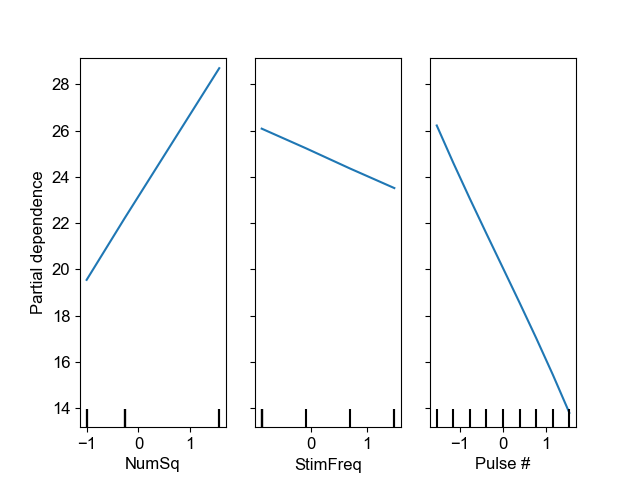

'\nExplanation:\nOriginal Features: original_features contains the names of the numeric features before any transformation.\nOne-Hot Encoded Features: The encoder.get_feature_names_out() method retrieves the names of the one-hot encoded features.\nInteraction Features: The poly.get_feature_names_out() method provides the names of all the features after the PolynomialFeatures transformation, including the interaction terms.\nRunning This Code:\nOutput: This code will print the mapping between the indices used in the partial dependence plots (e.g., x0, x1, x2) and the actual feature names. This will allow you to understand which specific features the plots are referring to.\nNext Steps:\nOnce you run the code, you can directly match x0, x1, and x2 to the features they represent. This will provide you with a clear understanding of which variables are influencing the peak_response predictions.\n'

In [43]:
# Generate Partial Dependence Plots
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt



# Step 9: Retrieve Feature Names for Interpretation
# Step 1: Original features before transformation
original_features = ['numSq', 'stimFreq', 'pulse']

# Get feature names from one-hot encoding
encoded_cellID = encoder_cellID.get_feature_names_out(['cellID'])
encoded_clampPotential = encoder_clampPotential.get_feature_names_out(['clampPotential'])

# Combine all feature names before polynomial expansion
all_feature_names = np.concatenate([original_features, encoded_cellID, encoded_clampPotential])

# Generate interaction term feature names using PolynomialFeatures
poly_feature_names = poly.get_feature_names_out(all_feature_names)

# Print the expanded feature names with their corresponding indices
for i, feature_name in enumerate(poly_feature_names):
    print(f"x{i} corresponds to feature: {feature_name}")
    if i == 10:
        break

# Generate partial dependence plots
x = PartialDependenceDisplay.from_estimator(svr, X_test_scaled, [0, 1, 2], grid_resolution=50)
x.axes_[0][0].set_xlabel('NumSq')
x.axes_[0][1].set_xlabel('StimFreq')
x.axes_[0][2].set_xlabel('Pulse #')
plt.show()
# save fig
paper_figure_export_location = Path(r"paper_figures\\Figure2v3\\")
plt.savefig(paper_figure_export_location / 'Fig2_SVM_partial_dependence_plots.svg', format='svg')
plt.savefig(paper_figure_export_location / 'Fig2_SVM_partial_dependence_plots.png', format='png')

'''
To identify which actual features correspond to x0, x1, and x2, we need to map the indices used in the partial dependence plots to the actual features in your dataset. Here’s how you can do that:

Step-by-Step Process:
Understand the Feature Transformation:

We applied one-hot encoding to cellID and clampPotential, and then generated interaction terms using PolynomialFeatures.
This process expands the original feature space into a larger set of features, where the first few indices correspond to the original features and the subsequent indices correspond to the one-hot encoded features and interaction terms.
Retrieve the Original and Expanded Feature Names:

We can use the PolynomialFeatures object to retrieve the expanded feature names, which will help us map the indices used in the partial dependence plots to the actual features.
'''

'''
Explanation:
Original Features: original_features contains the names of the numeric features before any transformation.
One-Hot Encoded Features: The encoder.get_feature_names_out() method retrieves the names of the one-hot encoded features.
Interaction Features: The poly.get_feature_names_out() method provides the names of all the features after the PolynomialFeatures transformation, including the interaction terms.
Running This Code:
Output: This code will print the mapping between the indices used in the partial dependence plots (e.g., x0, x1, x2) and the actual feature names. This will allow you to understand which specific features the plots are referring to.
Next Steps:
Once you run the code, you can directly match x0, x1, and x2 to the features they represent. This will provide you with a clear understanding of which variables are influencing the peak_response predictions.
'''


'''The partial dependence plots you generated show how the model's predictions (`peak_response`) change as each of the three selected features (indexed by `x0`, `x1`, and `x2`) varies, while keeping other features fixed at their average values.

### Interpreting the Plots:

1. **x0 (Left Plot)**:
   - The line has an upward slope, indicating that as the value of this feature increases, the predicted `peak_response` also increases.
   - This suggests that `x0` has a positive relationship with `peak_response`.

2. **x1 (Middle Plot)**:
   - The line is relatively flat and slightly decreasing, indicating a weak negative relationship between `x1` and `peak_response`.
   - The feature `x1` does not have a strong impact on the predictions, as the change in `peak_response` is minimal across the range of `x1`.

3. **x2 (Right Plot)**:
   - The line has a downward slope, indicating that as the value of `x2` increases, the predicted `peak_response` decreases.
   - This suggests that `x2` has a negative relationship with `peak_response`.

### Additional Insights:
- **Feature Impact**: The steeper the slope of the line, the greater the impact that feature has on the predictions. From the plots, `x0` seems to have the most significant positive impact, while `x2` has a noticeable negative impact.
- **Potential Non-Linearity**: If any of the plots showed non-linear trends (e.g., curves or bends), it would suggest a more complex relationship between the feature and `peak_response`. In your case, the relationships appear linear.

### Next Steps:
1. **Identify Feature Names**: Match `x0`, `x1`, and `x2` to the actual features they represent. This will help in interpreting which specific variables are influencing the predictions.
2. **Further Analysis**: If necessary, you can generate partial dependence plots for other features or even for interaction effects to gain more insights.
3. **Model Refinement**: Based on these insights, you might consider further tuning or simplifying the model, focusing on the most impactful features.

Let me know if you want to explore anything further or if you need help identifying the specific features corresponding to `x0`, `x1`, and `x2`.'''

In [44]:
from sklearn.inspection import permutation_importance

# Calculate permutation feature importance
result = permutation_importance(svr, X_test_scaled, y_test, n_repeats=10, random_state=42)
print("Feature Importances:\n", result.importances_mean[:10])

Feature Importances:
 [0.01048259 0.03071187 0.02818822 0.00368712 0.00298286 0.04324722
 0.00671497 0.07684646 0.02794861 0.02175538]


## prediction plot

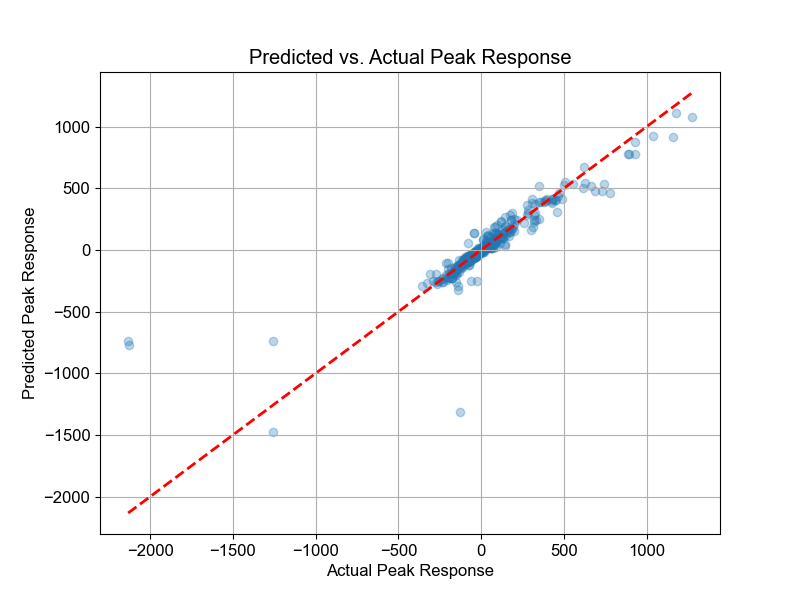

'\nInterpretation: Ideally, points should lie close to the red dashed line (where predicted = actual). Deviations indicate areas where the model could be improved.\n'

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Peak Response')
plt.ylabel('Predicted Peak Response')
plt.title('Predicted vs. Actual Peak Response')
plt.grid(True)
plt.show()

# save fig
paper_figure_export_location = Path(r"paper_figures\\Figure2v3\\")
plt.savefig(paper_figure_export_location / 'Fig2_SVM_predicted_vs_actual.svg', format='svg')
plt.savefig(paper_figure_export_location / 'Fig2_SVM_predicted_vs_actual.png', format='png')
'''
Interpretation: Ideally, points should lie close to the red dashed line (where predicted = actual). Deviations indicate areas where the model could be improved.
'''

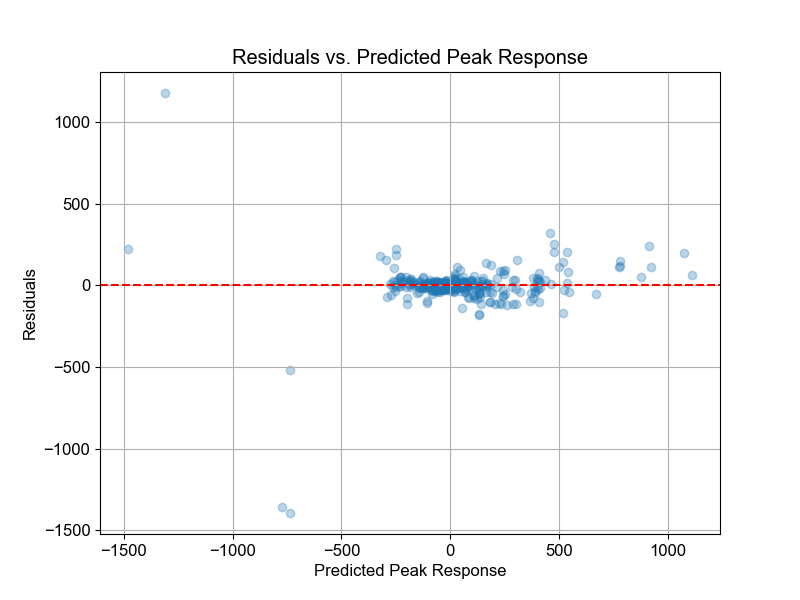

'\nInterpretation: Residuals should be randomly distributed around zero.\nPatterns or systematic deviations indicate areas where the model could be missing key relationships.\n'

In [46]:
# residual plot
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.3)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Peak Response')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Peak Response')
plt.grid(True)
plt.show()

# save fig
paper_figure_export_location = Path(r"paper_figures\\Figure2v3\\")
plt.savefig(paper_figure_export_location / 'Fig2_SVM_residuals_vs_predicted.svg', format='svg')
plt.savefig(paper_figure_export_location / 'Fig2_SVM_residuals_vs_predicted.png', format='png')
'''
Interpretation: Residuals should be randomly distributed around zero.
Patterns or systematic deviations indicate areas where the model could be missing key relationships.
'''

## Partial dependence plots

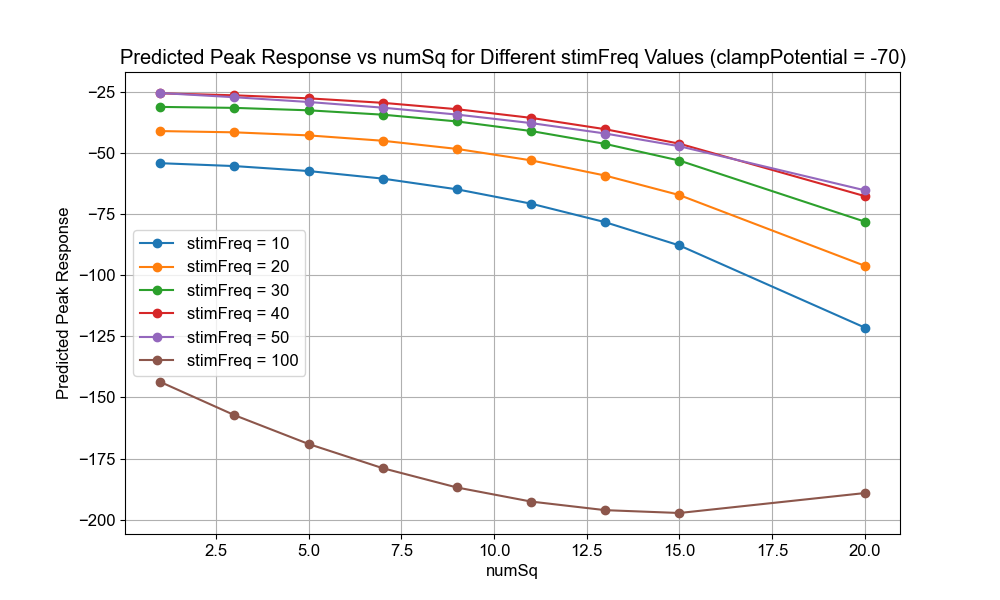

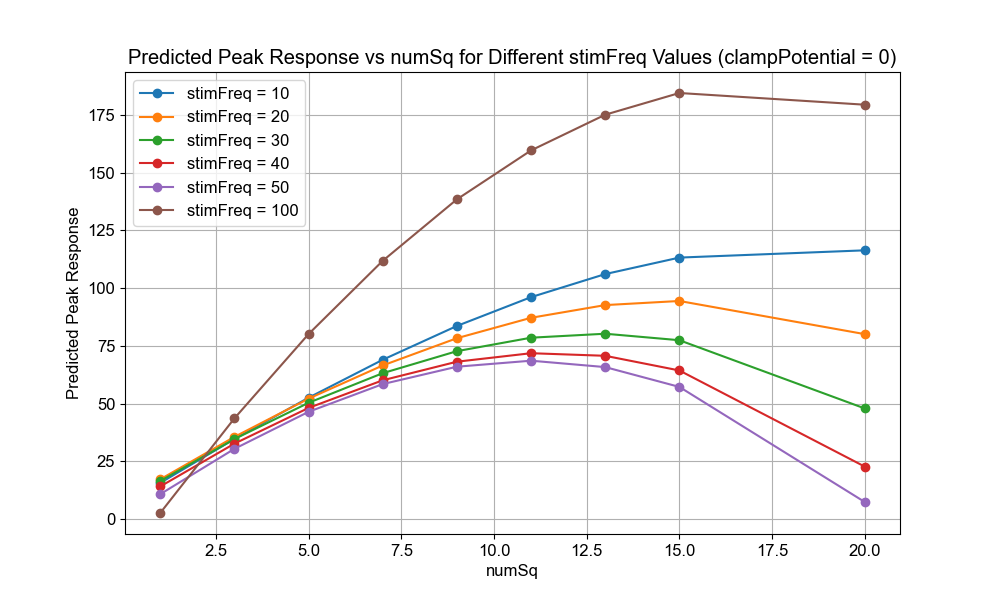

In [48]:
import numpy as np
import matplotlib.pyplot as plt

# Define the specific values for numSq and stimFreq
numSq_values = [1, 3, 5, 7, 9, 11, 13, 15, 20]
stimFreq_values = [10, 20, 30, 40, 50, 100]
clampPotential_values = [-70, 0]

# Loop through each clampPotential value to create separate plots
for clamp_value in clampPotential_values:
    predictions = {stimFreq: [] for stimFreq in stimFreq_values}

    # Make predictions for each combination of numSq and stimFreq for the current clampPotential value
    for numSq_value in numSq_values:
        for stimFreq_value in stimFreq_values:
            pred = svr.predict(
                scaler.transform(
                    poly.transform(
                        [[numSq_value, stimFreq_value, np.median(df_aggregated['pulse'])] 
                         + list(cellID_encoded[0]) 
                         + list(encoder_clampPotential.transform(pd.DataFrame({'clampPotential': [clamp_value]})).flatten())
                        ]
                    )
                )
            )[0]
            predictions[stimFreq_value].append(pred)

    # Plot the results for the current clampPotential value
    plt.figure(figsize=(10, 6))
    for stimFreq_value in stimFreq_values:
        plt.plot(numSq_values, predictions[stimFreq_value], marker='o', label=f'stimFreq = {stimFreq_value}')
    
    plt.xlabel('numSq')
    plt.ylabel('Predicted Peak Response')
    plt.title(f'Predicted Peak Response vs numSq for Different stimFreq Values (clampPotential = {clamp_value})')
    plt.legend()
    plt.grid(True)
    plt.show()

    # save fig
    paper_figure_export_location = Path(r"paper_figures\\Figure2v3\\")
    plt.savefig(paper_figure_export_location / f'Fig2_SVM_predicted_peak_response_vs_numSq_stimFreq_{clamp_value}.svg', format='svg')
    plt.savefig(paper_figure_export_location / f'Fig2_SVM_predicted_peak_response_vs_numSq_stimFreq_{clamp_value}.png', format='png')



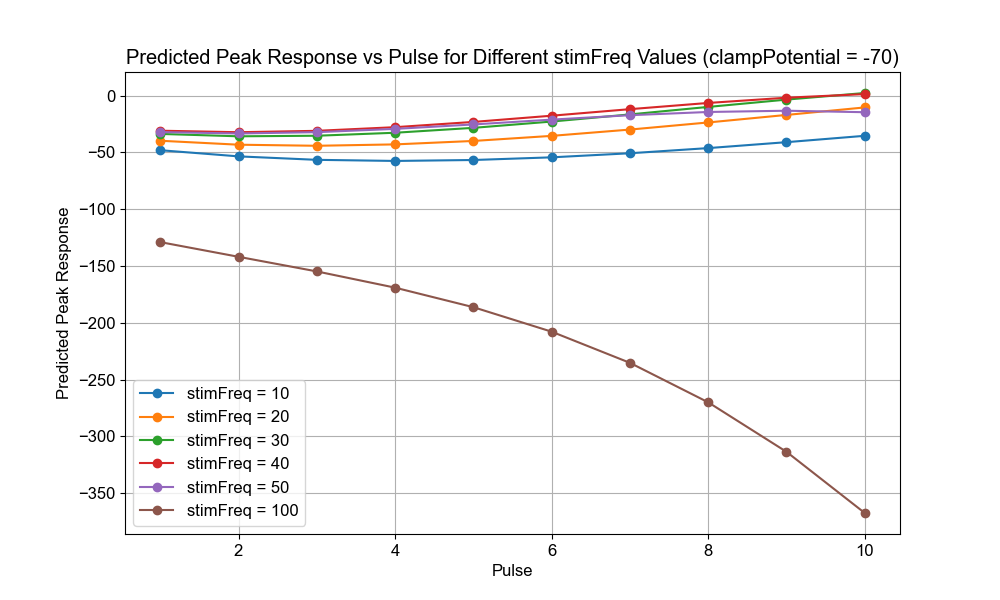

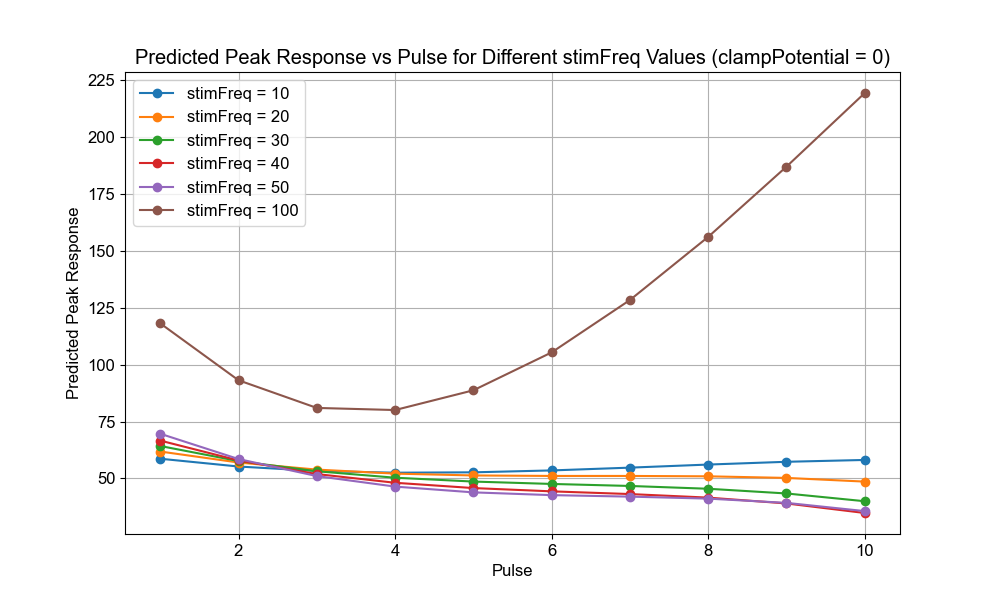

In [49]:
import numpy as np
import matplotlib.pyplot as plt

# Define the specific values for stimFreq and pulse
stimFreq_values = [10, 20, 30, 40, 50, 100]
pulse_values = np.arange(1, 11)  # Pulse varies from 1 to 20 as integers
clampPotential_values = [-70, 0]

# Loop through each clampPotential value to create separate plots
for clamp_value in clampPotential_values:
    predictions = {stimFreq: [] for stimFreq in stimFreq_values}

    # Make predictions for each combination of stimFreq and pulse for the current clampPotential value
    for pulse_value in pulse_values:
        for stimFreq_value in stimFreq_values:
            pred = svr.predict(
                scaler.transform(
                    poly.transform(
                        [[np.median(df_aggregated['numSq']), stimFreq_value, pulse_value] 
                         + list(cellID_encoded[0]) 
                         + list(encoder_clampPotential.transform(pd.DataFrame({'clampPotential': [clamp_value]})).flatten())
                        ]
                    )
                )
            )[0]
            predictions[stimFreq_value].append(pred)

    # Plot the results for the current clampPotential value
    plt.figure(figsize=(10, 6))
    for stimFreq_value in stimFreq_values:
        plt.plot(pulse_values, predictions[stimFreq_value], marker='o', label=f'stimFreq = {stimFreq_value}')
    
    plt.xlabel('Pulse')
    plt.ylabel('Predicted Peak Response')
    plt.title(f'Predicted Peak Response vs Pulse for Different stimFreq Values (clampPotential = {clamp_value})')
    plt.legend()
    plt.grid(True)
    plt.show()

    # save fig
    paper_figure_export_location = Path(r"paper_figures\\Figure2v3\\")
    plt.savefig(paper_figure_export_location / f'Fig2_SVM_predicted_peak_response_vs_pulse_stimFreq_{clamp_value}.svg', format='svg')
    plt.savefig(paper_figure_export_location / f'Fig2_SVM_predicted_peak_response_vs_pulse_stimFreq_{clamp_value}.png', format='png')
    


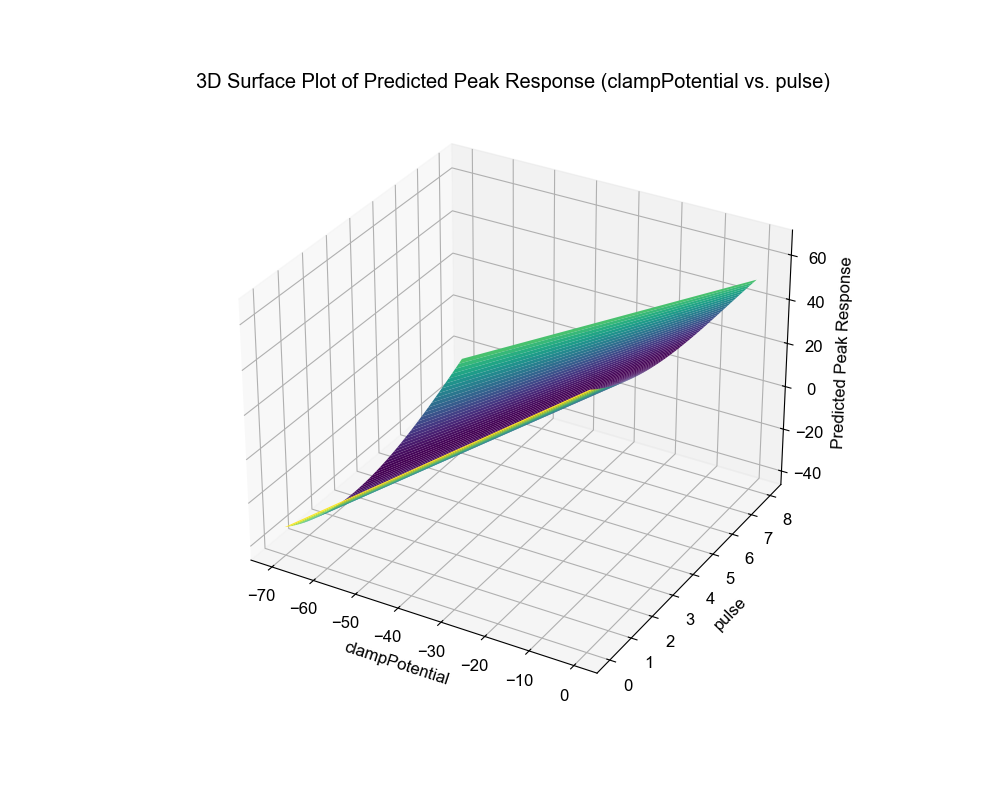

'\nInterpretation:\nThe 3D surface plot visualizes the predicted peak_response values across different combinations of clampPotential and pulse.\n'

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the discrete values for clampPotential and the range for pulse
clampPotential_values = [-70, 0]
pulse_range = np.linspace(df_aggregated['pulse'].min(), df_aggregated['pulse'].max(), 50)

# Create a grid for plotting, but loop over the clampPotential values
X, Y = np.meshgrid(clampPotential_values, pulse_range)

# Predict peak_response across the grid, keeping other variables constant
Z = np.array([
    [
        svr.predict(
            scaler.transform(
                poly.transform(
                    [[np.median(df_aggregated['numSq']), np.median(df_aggregated['stimFreq']), y] 
                     + list(cellID_encoded[0]) 
                     + list(encoder_clampPotential.transform(pd.DataFrame({'clampPotential': [x]})).flatten())
                    ]
                )
            )
        )[0]
        for x in clampPotential_values
    ]
    for y in pulse_range
])

# Create the 3D surface plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')

# Label the axes
ax.set_xlabel('clampPotential')
ax.set_ylabel('pulse')
ax.set_zlabel('Predicted Peak Response')

# Set the title
plt.title('3D Surface Plot of Predicted Peak Response (clampPotential vs. pulse)')

# Show the plot
plt.show()

# save fig
paper_figure_export_location = Path(r"paper_figures\\Figure2v3\\")
plt.savefig(paper_figure_export_location / 'Fig2_SVM_3D_surface_plot.svg', format='svg')
plt.savefig(paper_figure_export_location / 'Fig2_SVM_3D_surface_plot.png', format='png')

'''
Interpretation:
The 3D surface plot visualizes the predicted peak_response values across different combinations of clampPotential and pulse.
'''

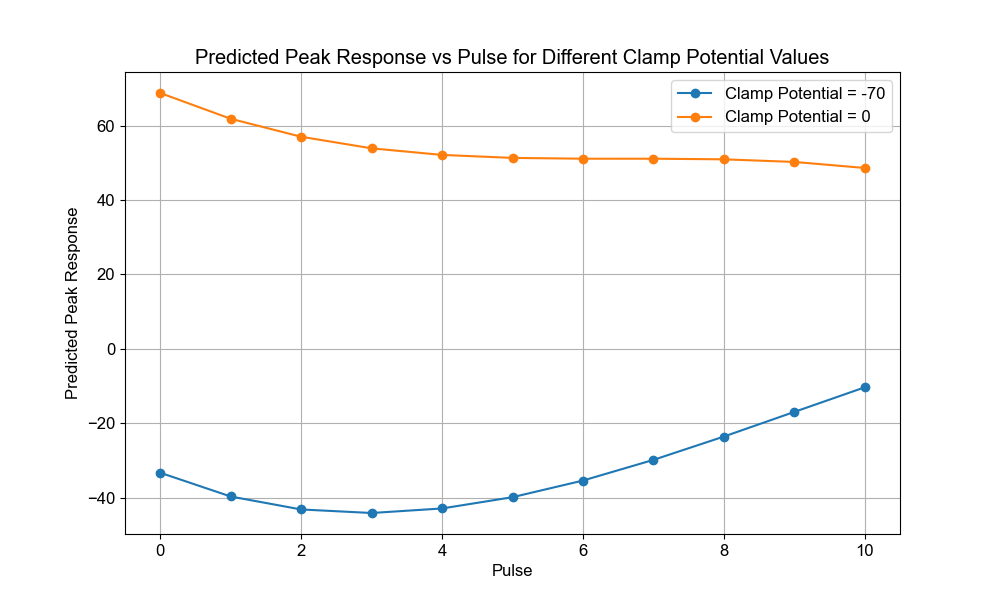

'\nInterpretation:\nThe line plot shows the predicted peak_response values across different pulse values for each clampPotential.\n'

In [53]:
import matplotlib.pyplot as plt

# Define the range for pulse as integers from 1 to 20
pulse_range = np.arange(0, 11)

# Initialize lists to store the results
predictions = {clamp_value: [] for clamp_value in clampPotential_values}

# Make predictions for each combination of pulse and clampPotential
for pulse_value in pulse_range:
    for clamp_value in clampPotential_values:
        pred = svr.predict(
            scaler.transform(
                poly.transform(
                    [[np.median(df_aggregated['numSq']), np.median(df_aggregated['stimFreq']), pulse_value] 
                     + list(cellID_encoded[0]) 
                     + list(encoder_clampPotential.transform(pd.DataFrame({'clampPotential': [clamp_value]})).flatten())
                    ]
                )
            )
        )[0]
        predictions[clamp_value].append(pred)

# Plot the results
plt.figure(figsize=(10, 6))
for clamp_value in clampPotential_values:
    plt.plot(pulse_range, predictions[clamp_value], marker='o', label=f'Clamp Potential = {clamp_value}')

plt.xlabel('Pulse')
plt.ylabel('Predicted Peak Response')
plt.title('Predicted Peak Response vs Pulse for Different Clamp Potential Values')
plt.legend()
plt.grid(True)
plt.show()

# save fig
paper_figure_export_location = Path(r"paper_figures\\Figure2v3\\")
plt.savefig(paper_figure_export_location / 'Fig2_SVM_predicted_peak_response_vs_pulse.svg', format='svg')
plt.savefig(paper_figure_export_location / 'Fig2_SVM_predicted_peak_response_vs_pulse.png', format='png')

'''
Interpretation:
The line plot shows the predicted peak_response values across different pulse values for each clampPotential.
'''
